In [2]:
import warnings
warnings.filterwarnings("ignore")

# Spatial Data

In [3]:
import pandas  # to store data structures and perform analysis
import osmnx  # to fetch network data from OpenStreetMap
import geopandas  # to store and plot geographical shapes
import xarray  # to store surface structures
import matplotlib.pyplot as plt  # for general plotting

We will spend this chapter discussing how Python represents data *once read* from a file or database, rather than focusing on specific *file* formats used to store data. This is because the libraries we use will read any format into one of a few canonical data structures. We take this approach because these data structures are what we interact with during our data analysis: they our interface with the data. Indeed, part of the benefit of Python (and other computing languages) is *abstraction*. The complexities, particularities and quirks associated with each file format are removed as Python represents all data in a few standard ways, regardless of provenance. We take full advantage of this feature here. 

We'll provide examples of three main data structures that are used in geographic data science:
- Geographic tables: A table of information where rows are objects (e.g. countries) and columns are attributes (e.g. their borders). They are handled in python using the package `GeoPandas`.
- Surface stuctures: A grid layout of the environment where each cell stores information on an attribute. Multiple grids can be used to store information on multiple attributes. These are handled in python using the package `xarray`.
- Spatial networks: A network of nodes (e.g. cities) and edges (e.g. roads that connect them) that define features and how they are connected. These are handled in python using the package `networkx`.

## Geographic Tables

Geographic objects are usually matched to what we called the *geographic table*. Geographic tables are essentially tables where each row represents a single geographic object and each column stores information about the object, its attributes or features. Typically, there is a special column in this table that records the *geometry* of the object. In python, these are typically stored and handled using the `geopandas` package.

We will refer to a measurement about an observation as a *feature*, and one set of measurements is a *sample*. For tables, this means a feature is a column and a sample is a row. Historically, though, geographic information scientists have used the word "feature" to mean an individual observation, since a "feature" in cartography is an entity on a map, and "attribute" to describe characteristics of that observation.

To understand the structure of geographic tables, it will help to read in the `countries_clean.gpkg` dataset that describes countries in the world. To read in this data, we can use the `read_file()` method in `geopandas`.

In [4]:
gt_polygons = geopandas.read_file("data/countries_clean.gpkg")

And we can examine the top of the table with the `.head()` method:

In [5]:
gt_polygons.head()

,ADMIN,geometry
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


Each row of this table is a single country. Each country only has two features: the administrative name of the country and the geometry of the country's boundary. The name of the country is encoded in the `ADMIN` column using the Python `str` type, which is used to store text-based data. The geometry of the country's boundary is stored in the `geometry` column, and is encoded using a special class in Python that is used to represent geometric objects. As with other table-based data structures in Python, every row and column have an index that identifies them uniquely and is rendered in bold on the left-hand side of the table. This geographic table is an instance of the `geopandas.GeoDataFrame` object, used throughout Python's ecosystem to represent geographic data.

Geographic tables store geographic information as an additional column. But, how is this information encoded? To see, we can check the type of the object in the first row:

In [6]:
type(gt_polygons.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

In `geopandas` (as well as other packages representing geographic data), the `geometry` column has special traits which a "normal" column, such as `ADMIN`, does not. For example, when we plot the dataframe, the `geometry` column is used as the main shape to use in the plot:

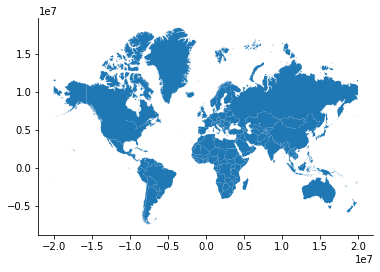

In [7]:
gt_polygons.plot();

Changing geometries must be done carefully: since the `geometry` column is special, there are special functions to adjust the geometry. For example, if we wanted to represent each country using its *centroid*, a point in the middle of the shape, then we must take care to make sure that a new geometry column was set properly using the `set_geometry()` method. This can be useful when you want to work with two different geometric representations of the same underlying sample. 

Let us make a map of both the boundary and the centroid of a country. First, to compute the centroid, we can use the `gt_polygons.geometry.centroid` property. This gives us the point that minimizes the average distance from all other points on the boundary of the shape. Storing that back to a column, called `centroid`:

In [8]:
gt_polygons['centroid'] = gt_polygons.geometry.centroid

We now have an additional feature:

In [9]:
gt_polygons.head()

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",POINT (12211696.493 422897.505)
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-7959811.948 -4915458.802)
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-8277554.831 -1032942.536)


Despite the fact that `centroid` is a geometry, it is not currently set as the geometry for our table. We can switch to the `centroid` column using the `set_geometry()` method. Finally, we can plot the centroid and the boundary of each country by switching the geometry column with `set_geometry`:

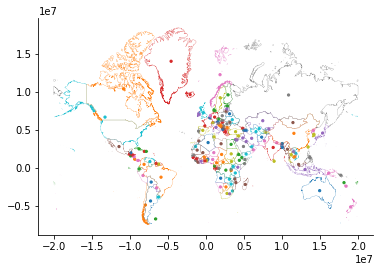

In [10]:
# Plot centroids
ax = gt_polygons.set_geometry('centroid').plot('ADMIN', markersize=5)

# Plot polygons without color filling
gt_polygons.plot('ADMIN', 
                 ax=ax, 
                 facecolor='none', 
                 edgecolor='k', 
                 linewidth=.2
                );

Note how we can create a map by calling `.plot()` on a `GeoDataFrame`. We can thematically color each feature based on a column by passing the name of that column to the plot method (as we do on with `ADMIN` in this case).

Thus, as should now be clear, nearly any kind of geographic object can be represented in one (or more) geometry column(s). Thinking about the number of different kinds of shapes or geometries one could draw quickly boggles the mind. Fortunately the Open Geospatial Consortium (OGC) has defined a set of "abstract" types that can be used to define any kind of geometry. This specification, codified in ISO 19125-1---the "simple features" specification---defines the formal relationships between these types: a `Point` is a zero-dimensional location with an x and y coordinate; a `LineString` is a path composed of a set of more than one `Point`, and a `Polygon` is a surface that has at least one LineString that starts and stops with the same coordinate. All of these types *also* have `Multi` variants that indicate a collection of multiple geometries of the same type. So, for instance, Bolivia is represented as a single polygon:

In [11]:
gt_polygons.query('ADMIN == "Bolivia"')

,ADMIN,geometry,centroid
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)


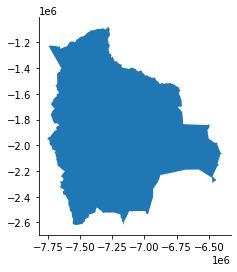

In [12]:
gt_polygons.query('ADMIN == "Bolivia"').plot();

while Indonesia is a `MultiPolygon` containing many `Polygons` for each individual island in the country:

In [13]:
gt_polygons.query('ADMIN == "Indonesia"')

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)


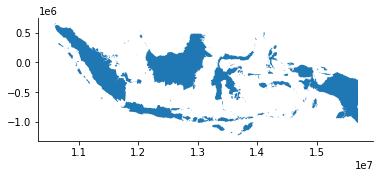

In [14]:
gt_polygons.query('ADMIN == "Indonesia"').plot();

In many cases, geographic tables will have geometries of a single type; records will *all* be `Point` or `LineString`, for instance. However, there is no formal requirement that a *geographic table* has geometries that all have the same type. 

Points are the simplest type of feature in that they do not have any dimension, only a pair of coordinates attached to them. This means that points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. The Tokyo dataset is an example of this. The data is stored as a comma-separated value table, or `.csv`:

In [15]:
gt_points = pandas.read_csv("data/tokyo_clean.csv")

Since we have read it with `pandas`, the table is loaded as a `DataFrame`, with no explicit spatial dimension:

In [16]:
type(gt_points)

pandas.core.frame.DataFrame

If we inspect the table, we find there is not a `geometry` column:

In [17]:
gt_points.head()

,user_id,longitude,latitude,date_taken,time_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09,17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10,16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21,15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11,05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06,16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


Many point datasets are provided in this format. To make the most of them, it is convenient to convert them into `GeoDataFrame` tables. There are two steps involved in this process:

1. Turn coordinates into geometries:

In [18]:
pt_geoms = geopandas.points_from_xy(x=gt_points["longitude"],
                                    y=gt_points["latitude"],
                                    crs="EPSG:4326"
                                   )
pt_geoms

<GeometryArray>
 ...
Length: 10000, dtype: geometry

2. Create a `GeoDataFrame` object:

In [20]:
gt_points = geopandas.GeoDataFrame(gt_points,
                                   geometry=pt_geoms
                                  )

And now `gt_points` looks and feels exactly like the one of countries we have seen before, with the difference the `geometry` column stores `POINT` geometries:

In [21]:
gt_points.head()

,user_id,longitude,latitude,date_taken,time_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09,17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10,16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)
2,62068690@N00,139.765632,35.694482,2008-12-21,15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,POINT (139.76563 35.69448)
3,49503094041@N01,139.784391,35.548589,2011-11-11,05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,POINT (139.78439 35.54859)
4,40443199@N00,139.768753,35.671521,2006-04-06,16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,POINT (139.76875 35.67152)


## Surfaces

Surfaces are used to record data from a field data model. In theory, a field is a continuous surface and thus has an infinite number of locations at which it could be measured. In reality however, fields are measured at a finite sample of locations that, to provide a sense of continuity and better conform with the field model, are uniformly structured across space. Surfaces thus, are represented as grids where each cell contains a sample. A grid can also be thought of as a table with rows and columns that are directly tied to geographic location (e.g. latitude and longitude). This is in sharp contrast with geographic tables, where geography is confined to a single column.

To explore how Python represents surfaces, we will use an extract for the Brazilian city of Sao Paulo of a [global population dataset](../data/ghsl/build_ghsl_extract). This dataset records population counts in cells of the same dimensions uniformly covering the surface of the Earth. Our extract is available as a GeoTIF file, a variation of the TIF image format that includes geographic information. We can use the `open_rasterio()` method from the `xarray` package to read in the GeoTIF:

In [22]:
pop = xarray.open_rasterio("data/ghsl_sao_paulo.tif")

This reads the data into a `DataArray` object:

In [23]:
type(pop)

xarray.core.dataarray.DataArray

`xarray` is a package to work with multi-dimensional labeled arrays. Let's unpack this: we can use arrays of not only two dimensions as in a table with rows and columns, but with an arbitrary number of them; each of these dimensions are "tracked" by an index that makes it easy and efficient to manipulate. In `xarray`, these indices are called coordinates, and they can be retrieved from our `DataArray` through the `coords` attribute:

In [24]:
pop.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

Interestingly, our surface has *three* dimensions: `x`, `y`, and `band`. The former two track the latitude and longitude that each cell in our population grid covers. The third one has a single value (1) and, in this context, it is not very useful. But it is easy to imagine contexts where a third dimension would be useful. For example, an optical color image may have three bands: red, blue, and green. More powerful sensors may pick up additional bands, such as near infrared (NIR) or even radio bands. A geographic surface will thus have two dimensions recording the location of cells (`x` and `y`), and at least one `band` that records other dimensions pertaining to our data.

An `xarray.DataArray` object contains additional information about the values stored under the `attrs` attribute:

In [25]:
pop.attrs

{'transform': (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0),
 'crs': '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True',
 'res': (250.0, 250.0),
 'is_tiled': 0,
 'nodatavals': (-200.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area',
 'grid_mapping': 'spatial_ref'}

In this case, we can see this includes information required to convert pixels in the array into locations on the Earth surface (e.g., `transform`, and `crs`), the resolution (250 meters by 250 meters), and other metadata that allows us to better understand where the data comes from and how it is stored.

Thus, our `DataArray` has three dimensions:
(band (how many layers the image has), X Y):

In [26]:
pop.shape

(1, 416, 468)

A common operation will be to reduce this to only the two geographic ones. We can do this with the `sel` operator, which allows us to select data by the value of their coordinates:

In [27]:
pop.sel(band=1)

<xarray.DataArray (y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
Attributes:
    transform:      (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0)
    crs:            +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +...
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-200.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

The resulting object is thus a two-dimensional array. Similar to geographic tables, we can quickly plot the values in our dataset:

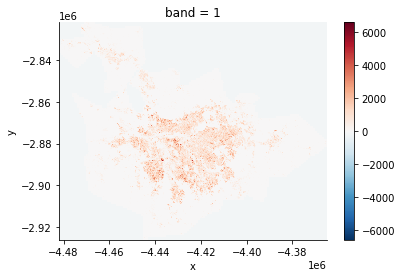

In [28]:
pop.sel(band=1).plot();

This gives us a first overview of the distribution of population in the Sao Paulo region. However, if we inspect further, we can see that the map includes negative counts! How could this be? As it turns out, missing data are traditionally stored in surfaces not as a class of its own (e.g., `NaN`) but with an impossible value. If we return to the `attrs` printout above, we can see how the `nodatavals` attribute specifies missing data recorded with -200. With that in mind, we can use the `where()` method to select only values that are *not* -200:

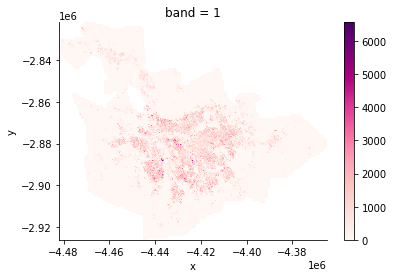

In [29]:
pop.where(pop!=-200)\
   .sel(band=1)\
   .plot(cmap="RdPu");

The colorbar now looks more sensible, and indicates *real* counts, rather than including the missing data placeholder values.

## Spatial graphs

Spatial graphs store connections between objects through space. These connections may derive from geographical topology (e.g., contiguity), distance, or more sophisticated dimensions such as interaction flows (e.g., commuting, trade, communication). Compared to geographic tables and surfaces, spatial graphs are rather different. First, in most cases they do not record measurements about a given phenomena, but instead focus on *connections*, on storing relationships between objects as they are facilitated (or impeded in their absence) by space. Second, because of this relational nature, the data are organised in a more unstructured fashion: while one sample may be connected to only one other sample, another one can display several links. This in stark contrast to geographic tables and surfaces, both of which have a clearly defined structure, shape and dimensionality in which data are organized. These particularities translate into a different set of Python data structures. Unlike the previous ones we have seen, there are different data structures to represent spatial graphs, each optimized for different contexts. One of such cases is the integration of spatial connections in statistical methods such as exploratory data analysis or regression. For this, the most common data structure are spatial weights matrices.

In this chapter, we briefly review a different way of representing spatial graphs that is much closer to the mathematical concept of a graph. A graph is composed of *nodes* that are linked together by *edges*. In a spatial network, *nodes* may represent geographical places, and thus have a specific location; likewise, *edges* may represent geographical paths between these places. Networks require both *nodes* and *edges* to analyze their structure. 

For illustration, we will rely on the `osmnx` library, which can query data from OpenStreetMap. For example, we extract the street-based graph of Yoyogi Park, near our earlier data from Tokyo:

In [30]:
%%time
graph = osmnx.graph_from_place("Yoyogi Park, Shibuya, Tokyo, Japan")

CPU times: user 1.54 s, sys: 6.71 ms, total: 1.55 s
Wall time: 1.58 s


In [ ]:
osmnx.save_graphml(graph, "data/yoyogi_park_graph.graphml")

The code snippet above sends the query to the OpenStreetMap server to fetch the data. Note that the cell above _requires_ internet connectivity to work. If you are working on the book _without_ connectivity, a cached version of the graph is available on the data folder and can be read as:

In [ ]:
graph = osmnx.load_graphml("data/yoyogi_park_graph.graphml")

Once the data is returned to `osmnx`, it gets processed into the `graph` Python representation:

In [31]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

We can have a quick inspection of the structure of the graph with the `plot_graph` method:

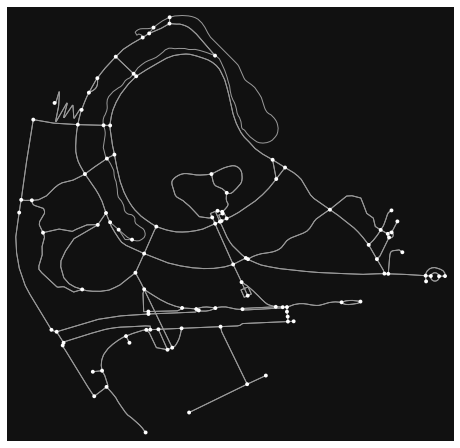

In [32]:
osmnx.plot_graph(graph);

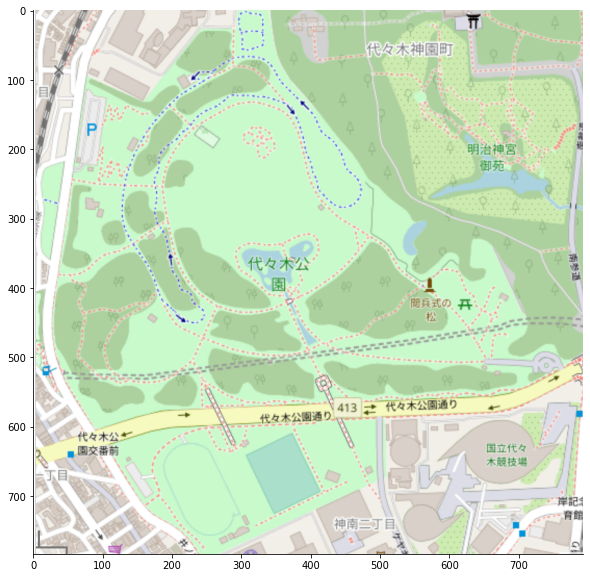

In [33]:
plt.figure(figsize = (10,10))
plt.imshow(plt.imread('yoyogi_park.png'))


The resultant `graph` object is actually a `MultiDiGraph` from `networkx`, a graph library written in Python. The graph here is stored as a collection of 106 nodes (street intersections):

In [34]:
len(graph.nodes)

106

and 287 edges (streets) that connect them:

In [35]:
len(graph.edges)

287

If we call graph.nodes we can see a list of their unique identifiers.

In [36]:
graph.nodes

NodeView((886196069, 886196073, 886196100, 886196106, 886196117, 886196121, 886196146, 886196187, 886196195, 886203360, 886229752, 1090844591, 1090844595, 1519651349, 1519651365, 1519651398, 1519651420, 1519651425, 1519651427, 1520546535, 1520546559, 1520546563, 1520546570, 1520546581, 1520546584, 1520546691, 1520546813, 1520546819, 1520546857, 1520546948, 1520546959, 1520547110, 1520547158, 1520547162, 1520547206, 1520828508, 1520828606, 1520828667, 1520828692, 1520828705, 1520828711, 1520828715, 1520828758, 1520828875, 1520828883, 1520828893, 1520828906, 1520828940, 1520828944, 1520828988, 1520829007, 1520829011, 1520829017, 1520829032, 1520829034, 1520829045, 1520829109, 1520829125, 1520829210, 1520829212, 1520829226, 1520829246, 1520829265, 1520829300, 1520829326, 1520829345, 1520829357, 1520829364, 1520829378, 1520829462, 1520829509, 1913626649, 3010292752, 3010292753, 3010292756, 3010292757, 3010292759, 3010292785, 3010292798, 3010292804, 3010293622, 3010293634, 3010293660, 30102

We can use a node's ID to obtain more information, such as its location and number of connected edges.

In [37]:
graph.nodes[1520546819]

{'y': 35.6711267, 'x': 139.6925951, 'street_count': 4}

We can also obtain information about an edge that connects two nodes:

In [38]:
graph.edges[(1520546819, 3010293622, 0)]

{'osmid': 138670840,
 'highway': 'footway',
 'oneway': False,
 'length': 59.113,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fa134e03f10>}

Or how the different components of the graph relate to each other. For example, what other nodes are directly connected to node `1520546819`?

In [39]:
list(graph.adj[1520546819].keys())

[3010293622, 5764960322, 1913626649, 1520546959]

Thus, networks are easy to represent in Python, and are one of the three main data structures in geographic data science. 